# NoSQL (MongoDB) (sesión 1)

## Contenidos

* Introducción
* Instalación inicial de MongoDB
* Descarga de datos CSV
* Instalación de la librería `pymongo`
* Conexión a la base de datos
* El API de colección de MongoDB
* Búsqueda de documentos
* Borrado de documentos
* Inserción de elementos
* Operadores de colección
* Ejemplos básicos de agregación
* Ejercicios




## Introducción

![MongoDB](https://webassets.mongodb.com/_com_assets/cms/MongoDB_Logo_FullColorBlack_RGB-4td3yuxzjs.png)

Esta hoja muestra cómo acceder a bases de datos MongoDB y también a conectar la salida con Jupyter. Se puede utilizar el *shell* propio de MongoDB. La diferencia es que ese programa espera código Javascript y aquí trabajaremos con Python. A continuación, se introducen los conceptos básicos para la realización de consultas sencillas en Python.


En primer lugar n unas comprobaciones iniciales.

In [31]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [32]:
!sudo apt-get update -qq
!sudo apt-get install -y -qq gpg p7zip

## Instalación inicial de MongoDB (no necesaria si se utiliza Docker en local)


In [33]:
!wget -qO - https://www.mongodb.org/static/pgp/server-6.0.asc | sudo bash -c 'gpg --dearmor > /etc/apt/trusted.gpg.d/mongo-server-6.gpg'

In [34]:
%%bash
sudo adduser --system --no-create-home mongodb
sudo addgroup --system mongodb
sudo adduser mongodb mongodb

# create db -- note: this should agree with dbpath in mongod.conf
if [ ! -d /var/lib/mongodb ]; then
  sudo mkdir -p /var/lib/mongodb
  sudo chown mongodb:mongodb /var/lib/mongodb
fi

# create logdir -- note: this should agree with logpath in mongod.conf
if [ ! -d /var/log/mongodb ]; then
  sudo mkdir -p /var/log/mongodb
  sudo chown mongodb:mongodb /var/log/mongodb
fi

The system user `mongodb' already exists. Exiting.
The user `mongodb' is already a member of `mongodb'.


addgroup: The group `mongodb' already exists as a system group. Exiting.


In [35]:
!echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list

deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse


In [36]:
!sudo ln -sf /bin/true /bin/systemctl

In [37]:
!sudo apt-get update -qq
!sudo apt-get install -y -qq dialog mongodb-org

In [38]:
!sudo /usr/bin/mongod --config /etc/mongod.conf --fork

about to fork child process, waiting until server is ready for connections.
forked process: 6208
ERROR: child process failed, exited with 48
To see additional information in this output, start without the "--fork" option.


In [39]:
!mongod --version

db version v6.0.13
Build Info: {
    "version": "6.0.13",
    "gitVersion": "3b13907f9bdf6bd3264d67140d6c215d51bbd20c",
    "openSSLVersion": "OpenSSL 3.0.2 15 Mar 2022",
    "modules": [],
    "allocator": "tcmalloc",
    "environment": {
        "distmod": "ubuntu2204",
        "distarch": "x86_64",
        "target_arch": "x86_64"
    }
}


## Descarga de los datos en formato CSV

 - Formato: 7zipped
 - Ficheros:
   - **Comments**.csv
       - Id
       - PostId
       - Score
       - Text, e.g.: "@Stu Thompson: Seems possible to me - why not try it?"
       - CreationDate, e.g.:"2008-09-06T08:07:10.730"
       - UserId
   - **Posts**.csv
       - Id
       - PostTypeId
          - 1: Question
          - 2: Answer
       - ParentID (only present if PostTypeId is 2)
       - AcceptedAnswerId (only present if PostTypeId is 1)
       - CreationDate
       - Score
       - ViewCount
       - Body
       - OwnerUserId
       - LastEditorUserId
       - LastEditorDisplayName="Jeff Atwood"
       - LastEditDate="2009-03-05T22:28:34.823"
       - LastActivityDate="2009-03-11T12:51:01.480"
       - CommunityOwnedDate="2009-03-11T12:51:01.480"
       - ClosedDate="2009-03-11T12:51:01.480"
       - Title=
       - Tags=
       - AnswerCount
       - CommentCount
       - FavoriteCount
   - **Tags**.csv
    - Id
    - Count
    - ExcerptPostId
    - TagName
    - WikiPostId
   - **Users**.csv
     - Id
     - Reputation
     - CreationDate
     - DisplayName
     - EmailHash
     - LastAccessDate
     - WebsiteUrl
     - Location
     - Age
     - AboutMe
     - Views
     - UpVotes
     - DownVotes
   - **Votes**.csv
     - Id
     - PostId
     - VoteTypeId
        - ` 1`: AcceptedByOriginator
        - ` 2`: UpMod
        - ` 3`: DownMod
        - ` 4`: Offensive
        - ` 5`: Favorite - if VoteTypeId = 5 UserId will be populated
        - ` 6`: Close
        - ` 7`: Reopen
        - ` 8`: BountyStart
        - ` 9`: BountyClose
        - `10`: Deletion
        - `11`: Undeletion
        - `12`: Spam
        - `13`: InformModerator
     - CreationDate
     - UserId (only for VoteTypeId 5)
     - BountyAmount (only for VoteTypeId 9)

In [40]:
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002

--2024-02-21 15:15:40--  https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dsevilla/bd2-data/main/es.stackoverflow/es.stackoverflow.csv.7z.001 [following]
--2024-02-21 15:15:41--  https://raw.githubusercontent.com/dsevilla/bd2-data/main/es.stackoverflow/es.stackoverflow.csv.7z.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘es.stackoverflow.csv.7z.001.1’

es.stackoverflow.cs 100%[===================>] 100.00M  63.8MB/s    in 1.6s    

2024-02-21 1

In [41]:
!7zr x es.stackoverflow.csv.7z.001


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 104857600 bytes (100 MiB)

Extracting archive: es.stackoverflow.csv.7z.001
  0% 1 Open           --
Path = es.stackoverflow.csv.7z.001
Type = Split
Physical Size = 104857600
Volumes = 2
Total Physical Size = 200457538
----
Path = es.stackoverflow.csv.7z
Size = 200457538
--
Path = es.stackoverflow.csv.7z
Type = 7z
Physical Size = 200457538
Headers Size = 248
Method = LZMA2:24
Solid = +
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./Comments.csv
  Size:     160819553 bytes (154 MiB)
  Modified: 2024-01-21 23:51:00
with the file from archive:
  Path:     Comments.csv
  Size:     160819553 bytes (154 MiB)
  Modified: 2024-01-21 23:51:00
? (Y)es / (N)o / 

In [42]:
!head Users.csv

Id,AboutMe,AccountId,CreationDate,DisplayName,DownVotes,LastAccessDate,Location,Reputation,UpVotes,Views,WebsiteUrl
-1,"<p>Hola, no soy una persona real.</p><br/><br/><p>¡Soy un proceso que ayuda a mantener el sitio limpio!</p><br/><br/><p>Hago cosas como:</p><br/><br/><ul><br/><li>Dar empujoncitos a preguntas antiguas sin respuesta aproximadamente cada hora, para que atraigan algo de atención.</li><br/><li>Tener la propiedad de las preguntas y respuestas wiki para que nadie se lleve reputación por ellas</li><br/><li>Recibir la propiedad de los votos negativos en las publicaciones de spam o dañinas que son borradas permanentemente</li><br/><li>Tener la propiedad de las ediciones sugeridas por usuarios anónimos</li><br/><li><a href=""http://meta.stackoverflow.com/a/92006"">Quitar preguntas abandonadas</a></li><br/></ul><br/>",-1,2015-10-26T21:36:24.767,Comunidad,22504,2015-10-26T21:36:24.767,en la granja de servidores,1,10211,2516,
1,"<p>Dev #2 who helped create Stack Overflow currently

## Instalación de la librería `pymongo`


In [43]:
!pip install --upgrade pymongo

In [44]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `pymongo` para python. La cargamos a continuación.

In [45]:
import pymongo
from pymongo import MongoClient

## Conexión a la base de datos

La conexión se inicia con `MongoClient` en el `host` descrito en el fichero `docker-compose.yml` (`mongo`), o bien a `localhost` si lo estamos haciendo en Colab.

In [46]:
db_hostname = "localhost" if RunningInCOLAB else "mongo"

In [47]:
client = MongoClient(db_hostname,27017)
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [48]:
client.list_database_names()

['admin', 'config', 'local', 'stackoverflow']

In [49]:
import csv
from datetime import datetime
from tqdm.notebook import tqdm

def batched(iterable, n):
    from itertools import islice
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

def csv_to_mongo(file, coll):
    """
    Carga un fichero CSV en Mongo. file especifica el fichero, coll la colección
    dentro de la base de datos, y date_cols las columnas que serán interpretadas
    como fechas.
    """
    # Convertir todos los elementos que se puedan a números
    def to_numeric(d):
        try:
            return int(d)
        except ValueError:
            try:
                return float(d)
            except ValueError:
                return d

    def to_date(d):
        """To ISO Date. If this cannot be converted, return NULL (None)"""
        try:
            return datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f")
        except ValueError:
            return None

    def to_str(d):
        try:
          return str(d)
        except ValueError:
            return None

    coll.drop()

    with open(file, encoding='utf-8') as f:
        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)

        # Las columnas que contienen 'Date' se interpretan como fechas
        func_to_cols = list(map(lambda c: to_date if 'date' in c.lower() else to_numeric, columns))
        #func_to_cols = list(map(lambda c: to_date if 'date' in c.lower() else (to_numeric if not 'displayname' in c.lower() else to_str), columns))

        for batch in batched(tqdm(reader, desc='Leyendo e insertando filas...'), 10000):
            docs = []
            for row in batch:
                row = [func(e) for (func,e) in zip(func_to_cols, row)]
                docs.append(dict(zip(columns,row)))
            coll.insert_many(docs)

        print("¡Hecho!")

"""
La idea es guardar en una lista las
"""

Las bases de datos se crean conforme se nombran. Se puede utilizar la notación punto o la de diccionario. Las colecciones también.

In [94]:
db = client.stackoverflow
db = client['stackoverflow']

Ahora vemos que se ha creado una nueva BD `stackoverflow` en Mongo.

In [91]:
client.list_database_names()

['admin', 'config', 'local', 'stackoverflow']

## Colecciones en MongoDB

Las bases de datos están compuestas por un conjunto de **colecciones**. Cada colección aglutina a un conjunto de objetos (documentos) del mismo tipo, aunque como vimos en teoría, cada documento puede tener un conjunto de atributos diferente.

In [52]:
posts = db.posts
posts

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow'), 'posts')

Las colecciones en Mongo pueden cambiarse de nombre con la función `.rename`.

Vamos a crear una colección ficticia llamada *colleccion* para posteriormente renombrarla como *startwars*.

Al establecer el parámetro `dropTarget`a `True` forzamos a que, si ya existía una colección `starwars` sus datos se  sobreescriben por la nueva colección renombrada.

In [92]:
# creamos la colección
collection = db['coleccion']
docs = [{"id":1, "nombre":"Luke"},
        {"id":3, "nombre":"Leia"}]
collection.insert_many(docs)

# Ahora la renombramos
collection.rename('starwars', dropTarget = True)

result = db.list_collection_names()
for collect in result:
    print(collect)

starwars
comments
posts
libro
autor
users
tags
votes


## Importación de los ficheros CSV

Por ahora creamos una colección diferente para cada uno. Después estudiaremos cómo poder optimizar el acceso usando agregación.

In [54]:
csv_to_mongo('Posts.csv',db.posts)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [55]:
db.drop_collection( 'Users')
# csv_to_mongo('Users.csv',db.users)

{'ok': 0.0,
 'errmsg': 'ns not found',
 'code': 26,
 'codeName': 'NamespaceNotFound'}

¿Qué ha pasado? Un valor erróneo en atributo `DisplayName` de uno de los usuarios provoca que dicho valor se convierta a `int`. Posteriormente dicho valor no puede se almacenado por Mongo pues excede su rango de valores para int lanzando la excepción `OverflowError: MongoDB can only handle up to 8-byte ints`.

Para solucionarlo deberemos descomentar la línea `#func_to_cols = list(map(lambda c: to_date if 'date' in c.lower() else (to_numeric if not 'displayname' in c.lower() else to_str), columns))` dentro de la función `csv_to_mongo` (sin olvidar comentar la anterior).

Con ello forzamos a que el campo `DisplayName` sea siempre de tipo `str`.


In [56]:
csv_to_mongo('Votes.csv',db.votes)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [28]:
csv_to_mongo('Comments.csv',db.comments)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [29]:
csv_to_mongo('Tags.csv',db.tags)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [30]:
posts.count_documents({})

410346

## El API de colección de MongoDB

El API de colección en Python se puede encontrar aquí: https://docs.mongodb.com/drivers/pymongo/. La mayoría de libros y referencias muestran el uso de mongo desde Javascript, ya que el *shell* de MongoDB acepta ese lenguaje. La sintaxis con respecto a Python cambia un poco, y se puede seguir en el enlace anterior. Existe incluso un curso de la MongoDB University que se puede realizar de forma gratuita: https://learn.mongodb.com/learning-paths/using-mongodb-with-python

Con `.find_one` obtenemos el primer elemento de una colección.

In [57]:
post = posts.find_one()
post

{'_id': ObjectId('65d6153872a18e11d31c24cc'),
 'Id': 1,
 'AcceptedAnswerId': 2,
 'AnswerCount': 1,
 'Body': '<p>Estoy creando un servicio usando <em>ASP.NET WebApi</em>. Quiero añadir soporte para la negociación del tipo de contenido basado en extensiones en el <em>URI</em>, así que he añadido lo siguiente al código de inicialización del servicio:</p><br/><br/><pre><code>public static class WebApiConfig<br/>{<br/>  public static void Register(HttpConfiguration config)<br/>  {<br/>    config.Formatters.JsonFormatter.AddUriPathExtensionMapping("json", "application/json");<br/>    config.Formatters.XmlFormatter.AddUriPathExtensionMapping("xml", "application/xml");<br/>  }<br/>}<br/></code></pre><br/><br/><p>Para que esto funcione necesito crear dos rutas para cada acción del controlador (estoy usando exclusivamente enrutamiento basado en atributos):</p><br/><br/><pre><code>[Route("item/{id}/details")]<br/>[Route("item/{id}/details.{ext}")]<br/>[HttpGet]<br/>public ItemDetail[] GetItemDeta

Utilizo la librería `pp` (*PrettyPrint*) para imprimir los objetos grandes de una manera amigable.

In [58]:
users = db.users
pp(users.find_one())

{'AboutMe': '<p>Hola, no soy una persona real.</p><br/><br/><p>¡Soy un proceso '
            'que ayuda a mantener el sitio limpio!</p><br/><br/><p>Hago cosas '
            'como:</p><br/><br/><ul><br/><li>Dar empujoncitos a preguntas '
            'antiguas sin respuesta aproximadamente cada hora, para que '
            'atraigan algo de atención.</li><br/><li>Tener la propiedad de las '
            'preguntas y respuestas wiki para que nadie se lleve reputación '
            'por ellas</li><br/><li>Recibir la propiedad de los votos '
            'negativos en las publicaciones de spam o dañinas que son borradas '
            'permanentemente</li><br/><li>Tener la propiedad de las ediciones '
            'sugeridas por usuarios anónimos</li><br/><li><a '
            'href="http://meta.stackoverflow.com/a/92006">Quitar preguntas '
            'abandonadas</a></li><br/></ul><br/>',
 'AccountId': -1,
 'CreationDate': datetime.datetime(2015, 10, 26, 21, 36, 24, 767000),
 'DisplayName': 'C

A cada objeto se le asigna una clave implícita con nombre "`_id`" (si el objeto no lo incluye).

In [59]:
print (type(post['_id']))
post['_id']

<class 'bson.objectid.ObjectId'>


ObjectId('65d6153872a18e11d31c24cc')

La siguiente sintaxis está descatalogada en las nuevas versiones, pero era más conveniente:

In [60]:
#posts.save(post)

Ahora hay que hacerlo así (el resultado será 0 porque el documento no ha sido modificado desde que se leyó, pero sería 1 si el documento se modificó):

In [61]:
result = posts.replace_one({"_id": post['_id']}, post)
result.modified_count

0

## Búsqueda de documentos

Vamos a estudiar cómo buscar documentos en una colección de la BD.

En primer lugar con `.find_one` podemos buscar el primer elemento que cumpla una condición.


In [62]:
post = posts.find_one()
pp(post)

{'AcceptedAnswerId': 2,
 'AnswerCount': 1,
 'Body': '<p>Estoy creando un servicio usando <em>ASP.NET WebApi</em>. Quiero '
         'añadir soporte para la negociación del tipo de contenido basado en '
         'extensiones en el <em>URI</em>, así que he añadido lo siguiente al '
         'código de inicialización del '
         'servicio:</p><br/><br/><pre><code>public static class '
         'WebApiConfig<br/>{<br/>  public static void '
         'Register(HttpConfiguration config)<br/>  {<br/>    '
         'config.Formatters.JsonFormatter.AddUriPathExtensionMapping("json", '
         '"application/json");<br/>    '
         'config.Formatters.XmlFormatter.AddUriPathExtensionMapping("xml", '
         '"application/xml");<br/>  }<br/>}<br/></code></pre><br/><br/><p>Para '
         'que esto funcione necesito crear dos rutas para cada acción del '
         'controlador (estoy usando exclusivamente enrutamiento basado en '
         'atributos):</p><br/><br/><pre><code>[Route("item/{id}

In [63]:
for k,v in post.items():
    print("%s: %s" % (k,v))

_id: 65d6153872a18e11d31c24cc
Id: 1
AcceptedAnswerId: 2
AnswerCount: 1
Body: <p>Estoy creando un servicio usando <em>ASP.NET WebApi</em>. Quiero añadir soporte para la negociación del tipo de contenido basado en extensiones en el <em>URI</em>, así que he añadido lo siguiente al código de inicialización del servicio:</p><br/><br/><pre><code>public static class WebApiConfig<br/>{<br/>  public static void Register(HttpConfiguration config)<br/>  {<br/>    config.Formatters.JsonFormatter.AddUriPathExtensionMapping("json", "application/json");<br/>    config.Formatters.XmlFormatter.AddUriPathExtensionMapping("xml", "application/xml");<br/>  }<br/>}<br/></code></pre><br/><br/><p>Para que esto funcione necesito crear dos rutas para cada acción del controlador (estoy usando exclusivamente enrutamiento basado en atributos):</p><br/><br/><pre><code>[Route("item/{id}/details")]<br/>[Route("item/{id}/details.{ext}")]<br/>[HttpGet]<br/>public ItemDetail[] GetItemDetails(int id)<br/>{<br/>  return i

Además de `find_one()`, la función principal de búsqueda es `find()`. Esta función ofrece un conjunto muy ámplio de opciones para búsqueda, que estudiaremos a continuación.

Primero, una consulta sencilla, con el valor de un campo:

In [64]:
posts.count_documents({'PostTypeId':2})

211615

También existe `explain()`, al estilo de SQL.

In [65]:
posts.find({"PostTypeId": 2}).explain()

{'explainVersion': '1',
 'queryPlanner': {'namespace': 'stackoverflow.posts',
  'indexFilterSet': False,
  'parsedQuery': {'PostTypeId': {'$eq': 2}},
  'queryHash': 'D22C2013',
  'planCacheKey': 'D22C2013',
  'maxIndexedOrSolutionsReached': False,
  'maxIndexedAndSolutionsReached': False,
  'maxScansToExplodeReached': False,
  'winningPlan': {'stage': 'COLLSCAN',
   'filter': {'PostTypeId': {'$eq': 2}},
   'direction': 'forward'},
  'rejectedPlans': []},
 'executionStats': {'executionSuccess': True,
  'nReturned': 211615,
  'executionTimeMillis': 496,
  'totalKeysExamined': 0,
  'totalDocsExamined': 410346,
  'executionStages': {'stage': 'COLLSCAN',
   'filter': {'PostTypeId': {'$eq': 2}},
   'nReturned': 211615,
   'executionTimeMillisEstimate': 60,
   'works': 410347,
   'advanced': 211615,
   'needTime': 198731,
   'needYield': 0,
   'saveState': 410,
   'restoreState': 410,
   'isEOF': 1,
   'direction': 'forward',
   'docsExamined': 410346},
  'allPlansExecution': []},
 'command':

También se puede limitar la búsqueda con la función `.limit`

In [66]:
respuestas = posts.find({'PostTypeId': 2}).limit(10)

La respuesta no es un conjunto de elementos, sino un cursor que puede ir recorriéndose.

In [67]:
respuestas

In [68]:
list(respuestas)

[{'_id': ObjectId('65d6153872a18e11d31c24cd'),
  'Id': 2,
  'AcceptedAnswerId': '',
  'AnswerCount': '',
  'Body': '<p>He encontrado la solución.</p><br/><br/><p>Resulta que las rutas tienen asignada una <strong>precedencia</strong> numérica asignada, que el motor de enrutamiento de WebApi usa para decidir qué ruta usar en caso de conflicto. Las rutas creadas automáticamente para una misma acción siempre tienen una precedencia distinta, ¡pero la ruta que yo estaba creando manualmente tenía la misma precedencia que la ya existente!</p><br/><br/><p>Así pues la solución es añadir lo siguiente a <code>GetActionDirectRoutes</code>, inmediatamente después de <code>new RouteEntry</code>:</p><br/><br/><pre><code>entry.Route.DataTokens["precedence"] = <br/>    ((decimal)route.Route.DataTokens["precedence"]) - 0.1M;<br/></code></pre><br/>',
  'ClosedDate': None,
  'CommentCount': 2,
  'CommunityOwnedDate': None,
  'ContentLicense': 'CC BY-SA 3.0',
  'CreationDate': datetime.datetime(2015, 10, 29

También se puede importar en un Dataframe de `pandas`:

In [69]:
respuestas = posts.find({"PostTypeId": 2}).limit(30)
df = pd.DataFrame(respuestas)
df.head()

,_id,Id,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,ContentLicense,CreationDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,65d6153872a18e11d31c24cd,2,,,<p>He encontrado la solución.</p><br/><br/><p>...,None,2,None,CC BY-SA 3.0,2015-10-29 19:14:23.673,...,,,,23,1,2,31,,,
1,65d6153872a18e11d31c24cf,4,,,"<p><code>.AsString</code> devuelve el mismo ""<...",None,0,None,CC BY-SA 3.0,2015-10-30 00:45:47.640,...,,25,,24,3,2,6,,,
2,65d6153872a18e11d31c24d2,7,,,"<p>Lo de elegancia es algo difícil de decir, e...",None,0,None,CC BY-SA 3.0,2015-10-30 05:30:50.993,...,,29967,,25,5,2,29,,,
3,65d6153872a18e11d31c24d4,9,,,<p>Antes de responder directamente la respuest...,None,1,None,CC BY-SA 3.0,2015-10-30 13:59:47.113,...,,,,21,3,2,12,,,
4,65d6153872a18e11d31c24d6,11,,,<p>En el primer caso:</p><br/><br/><pre><code>...,None,2,None,CC BY-SA 3.0,2015-10-30 14:43:43.737,...,,25,,23,10,2,25,,,


<Axes: >

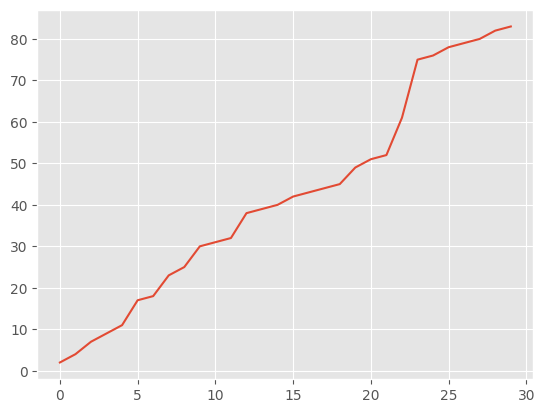

In [70]:
df['Id'].plot()

### Búsquedas anidadas

La función `find()` tiene un gran número de posibilidades para especificar la búsqueda. Se pueden utilizar cualificadores complejos como:

- `$and`
- `$or`
- `$not`

Estos calificadores unen "objetos", no valores. Por otro lado, hay otros calificadores que se refieren a valores:

- `$lt` (menor)
- `$lte` (menor o igual)
- `$gt` (mayor)
- `$gte` (mayor o igual)

In [71]:
respuestas = posts.find({ '$and' : [ {"PostTypeId": 2} ,
                                    {"Id" : {'$gte' : 100}} ]}).limit(10)
list(respuestas)

[{'_id': ObjectId('65d6153872a18e11d31c251a'),
  'Id': 102,
  'AcceptedAnswerId': '',
  'AnswerCount': '',
  'Body': '<pre><code>$ git reset --soft HEAD~  o $ git reset --soft HEAD~1       #1<br/>// Cambios necesarios //                                    #2<br/>$ git add ...                                               #3<br/>$ git commit ...                                            #4<br/></code></pre><br/><br/><p>Simplemente haces un reset soft, con lo que te quedas con los cambios en local pero deshaces el commit, después haces lo que quieras y vuelves a hacer el commit como querías la primera vez.</p><br/>',
  'ClosedDate': None,
  'CommentCount': 0,
  'CommunityOwnedDate': None,
  'ContentLicense': 'CC BY-SA 3.0',
  'CreationDate': datetime.datetime(2015, 12, 1, 19, 0, 31, 680000),
  'FavoriteCount': '',
  'LastActivityDate': datetime.datetime(2015, 12, 1, 19, 0, 31, 680000),
  'LastEditDate': None,
  'LastEditorDisplayName': '',
  'LastEditorUserId': '',
  'OwnerDisplayName':

Vamos ahora a obtener aquellas cuestiones que tengan un `Score`mayor a 100

In [72]:
respuestas = posts.find({ '$and' : [ {"PostTypeId": 1} ,
                                    {"Score" : {'$gt' : 100}} ]}).limit(10)
list(respuestas)

[{'_id': ObjectId('65d6153872a18e11d31c24ec'),
  'Id': 36,
  'AcceptedAnswerId': 40,
  'AnswerCount': 3,
  'Body': '<p>¿Cuál es la diferencia entre un <code>inner</code> y un <code>outer join</code>?</p><br/><p>Y ¿cuál es la función de los modificadores?</p><br/><ul><br/><li><code>left</code></li><br/><li><code>right</code></li><br/><li><code>full</code></li><br/></ul><br/>',
  'ClosedDate': None,
  'CommentCount': 1,
  'CommunityOwnedDate': None,
  'ContentLicense': 'CC BY-SA 4.0',
  'CreationDate': datetime.datetime(2015, 11, 2, 15, 31, 51, 453000),
  'FavoriteCount': '',
  'LastActivityDate': datetime.datetime(2023, 7, 12, 6, 22, 59, 157000),
  'LastEditDate': datetime.datetime(2020, 7, 23, 3, 20, 28, 683000),
  'LastEditorDisplayName': '',
  'LastEditorUserId': 128299,
  'OwnerDisplayName': '',
  'OwnerUserId': 21,
  'ParentId': '',
  'PostTypeId': 1,
  'Score': 141,
  'Tags': '<mysql><sql><join>',
  'Title': '¿Cuál es la diferencia entre un inner y un outer join?',
  'ViewCount': 

Con el método `.sort` podemos ordenar los resultados en base a un campo. Dependiendo del valor del segundo parámetros tendremos un orden
* Ascendente (1)
* Descendente (-1)

In [73]:
respuestas = posts.find({ '$and' : [ {"PostTypeId": 1} ,
                                    {"Score" : {'$gt' : 100}} ]}) \
                  .limit(10) \
                  .sort("LastActivityDate",1)
list(respuestas)

[{'_id': ObjectId('65d6153c72a18e11d31c7d0b'),
  'Id': 29177,
  'AcceptedAnswerId': 29198,
  'AnswerCount': 15,
  'Body': '<p>La mayoría de nosotros decimos, (muchas veces sin saber realmente),</p><br/><br/><blockquote><br/>  <p>“No utilizar variables globales”</p><br/></blockquote><br/><br/><hr><br/><br/><p><a href="http://martinfowler.com/">Martin Fowler</a> expresa en unos de sus libros, <a href="https://www.amazon.co.uk/gp/product/0321127420/ref=as_li_ss_tl?ie=UTF8&tag=mundogeek-21&linkCode=as2&camp=1634&creative=19450&creativeASIN=0321127420">Patterns of Enterprise Application Architecture</a>, que </p><br/><br/><blockquote><br/>  <p>“cualquier variable global es siempre culpable hasta que se demuestre<br/>  lo contrario”</p><br/></blockquote><br/><br/><ul><br/><li>¿Por qué es una mala practica usar variables globales?</li><br/><li>¿Realmente son perjudiciales?</li><br/><li>¿O se trata sólo de <strike>un odio irracional</strike> prejuicios por parte de los <em>puristas</em>?</li><

### Búsqueda por fechas

Es posible realizar búsquedas por fecha cuando los documentos incluyan atributos de ese tipo.

Para ello podemos usar `datetime` a la hora de definir los filtros.

In [74]:
start = datetime(2021, 9, 29)
end = datetime(2023, 9, 24)

respuestas = posts.find({
    '$and' : [
        {"LastActivityDate": {'$gte':start,'$lt': end}}
        ]
    }).limit(10)
list(respuestas)

[{'_id': ObjectId('65d6153872a18e11d31c24d8'),
  'Id': 14,
  'AcceptedAnswerId': '',
  'AnswerCount': '',
  'Body': '<p><strong>¿Qué es C++?</strong></p><br/><p>C++ es de tipado estático (statically typed), (por lo general) compilado, multi-paradigma, que no debe confundirse con C o C++ / CLI. Se desarrolló en la década de 1980 por Bjarne Stroustrup, inicialmente como un conjunto de extensiones para el lenguaje de programación C. Basándose en C, C++ ha mejorado la seguridad de tipos y ha añadido soporte para la gestión automática de recursos, la orientación a objetos, programación genérica, y el manejo de excepciones, entre otras características.</p><br/><p>Más información:</p><br/><ul><br/><li><a href="https://es.wikipedia.org/wiki/C%2B%2B" rel="nofollow noreferrer">Artículo sobre C++ en Wikipedia</a></li><br/><li><a href="https://isocpp.org/std/the-standard" rel="nofollow noreferrer">Estándar de C++</a></li><br/></ul><br/><p>Documentación:</p><br/><ul><br/><li><a href="https://en.cpp

### Búsqueda con una lista

Con el operador `$in` podemos comprobar si el valor de un campo se encuentra dentro de una lista.

Vamos a obtener todos los documentos que tengan entre sus `Tags` los lenguajes *javascript* o *java*.

In [75]:
respuestas = posts.find({'Tags': {'$in':['<javascript>', '<java>']}}).limit(3)
list(respuestas)

[{'_id': ObjectId('65d6153872a18e11d31c24e5'),
  'Id': 29,
  'AcceptedAnswerId': '',
  'AnswerCount': 2,
  'Body': '<p>Hoy intenté este algoritmo para medir a cuantos cuadros por segundo (FPS) se refresca mi pantalla (yo sé de antemano que son 50 FPS).</p><br/><br/><pre><code>function measureFpsAsync() {<br/>    requestAnimationFrame(function(t0) {<br/>        requestAnimationFrame(function(t1) {<br/>            fps = Math.round(1000/(t1 - t0));<br/>            alert(fps);<br/>        });<br/>    });<br/>}<br/>window.onload = measureFpsAsync;<br/></code></pre><br/><br/><p>Para mi sorpresa el resultado no fue 50, tampo un resultado estable, algunas veces resulta 25, otras 13, otras 7. Parece que se salta algunos "frames" (o cuadros) entre los callbacks. </p><br/><br/><p>Lo probé en Chrome, Firefox y Edge y siempre pasa lo mismo.</p><br/><br/><p>Luego intenté envolverlo en un <code>setTimeout</code> a ver que sucedía y funcionó, siempre me devuelve un resultado estable de 50 FPS.</p><br/

### Búsqueda con expresiones regulares

Aparte de los operadores visto arriba también es posible usar expresiones regulares con el operador `$regex`

*Más info sobre expresiones regulares en la [documentación oficial de Python](https://docs.python.org/3/howto/regex.html).*

Vamos extraer todas las preguntas de los usuarios cuyo título empiece por *python* o *Python*.

In [76]:
respuestas = posts.find({ '$and' : [ {"PostTypeId": 1} ,
                                    {"Title" : {'$regex' : '^[Pp]ython'}} ]})
list(respuestas)

[{'_id': ObjectId('65d6153872a18e11d31c2833'),
  'Id': 973,
  'AcceptedAnswerId': '',
  'AnswerCount': 3,
  'Body': '<br/><br/><p>Tengo escritos algunos programas en Python (uso Python 2.7, pero no tendría problemas para pasarme a Python 3) para analizar una base de datos alojada en MySQL (todo en <code>localhost</code>, así que no tengo ningún problema para conectarme). Los programas funcionan a la perfección en Debian... sin embargo, necesito también ejecutar estos análisis en una computadora Mac, y me enfrento al problema de que no está disponible el módulo <code>MySQLdb</code>.</p><br/><br/><p>Intenté instalar este módulo con <code>pip</code> (siguiendo las instrucciones descritas <a href="https://stackoverflow.com/questions/25794121/cant-install-python-mysql-on-os-x-10-10-yosemite">aquí</a> y <a href="https://stackoverflow.com/questions/1448429/how-to-install-mysqldb-python-data-access-library-to-mysql-on-mac-os-x">aquí también</a>) y al ejecutar mi código, me sigo topando con el 

## Borrado de documentos

A la hora de realizar el borrado de documentos debemos de usar los métodos `.delete_one`o `.delete_many` usando filtros de forma similar a como hemos empleado en las búsquedas.

Vamos a eliminar aquellas respuestas que tengan un `Score` menor a 10.

In [77]:
"""
resultado = posts.delete_many({ '$and' : [ {"PostTypeId": 2} ,
                                    {"Score" : {'$lt' : 10}} ]})
print(f'Borrados {resultado.deleted_count} documentos')
"""

'\nresultado = posts.delete_many({ \'$and\' : [ {"PostTypeId": 2} ,\n                                    {"Score" : {\'$lt\' : 10}} ]})\nprint(f\'Borrados {resultado.deleted_count} documentos\')\n'

## Inserción de elementos

A la hora de insertar elementos en MongoDB pude hacerse con los métodos `.insert_one` (para insertar un único documento) o `insert_many`para insertar múltiples documentos al mismo tiempo.



In [78]:
post_to_insert = posts.find_one()
post_to_insert['Body']='Texto de prueba'
pp(post_to_insert)

{'AcceptedAnswerId': 2,
 'AnswerCount': 1,
 'Body': 'Texto de prueba',
 'ClosedDate': None,
 'CommentCount': 2,
 'CommunityOwnedDate': None,
 'ContentLicense': 'CC BY-SA 4.0',
 'CreationDate': datetime.datetime(2015, 10, 29, 15, 56, 52, 933000),
 'FavoriteCount': '',
 'Id': 1,
 'LastActivityDate': datetime.datetime(2021, 3, 12, 17, 49, 40, 687000),
 'LastEditDate': datetime.datetime(2019, 7, 7, 21, 36, 17, 737000),
 'LastEditorDisplayName': 'user13558',
 'LastEditorUserId': '',
 'OwnerDisplayName': '',
 'OwnerUserId': 23,
 'ParentId': '',
 'PostTypeId': 1,
 'Score': 40,
 'Tags': '<.net><asp.net-web-api><asp.net>',
 'Title': 'La creación manual de un alias de ruta con un DirectRouteProvider '
          'personalizado causa un error "Multiple actions were found that '
          'match the request"',
 'ViewCount': 780,
 '_id': ObjectId('65d6153872a18e11d31c24cc')}


In [81]:
posts.insert_one(post_to_insert)

DuplicateKeyError: E11000 duplicate key error collection: stackoverflow.posts index: _id_ dup key: { _id: ObjectId('65d6153872a18e11d31c24cc') }, full error: {'index': 0, 'code': 11000, 'errmsg': "E11000 duplicate key error collection: stackoverflow.posts index: _id_ dup key: { _id: ObjectId('65d6153872a18e11d31c24cc') }", 'keyPattern': {'_id': 1}, 'keyValue': {'_id': ObjectId('65d6153872a18e11d31c24cc')}}

¿Por qué ha fallado? Si comprobamos detenidamente el documento, vemos que contiene el campo `_id` por lo que MongoDB nos informa que ya hay un documento con ese identificador. Por tanto, debemos de eliminar dicho campo del documento antes de insertarlo como uno nuevo.

In [ ]:
post_to_insert.pop('_id',None) #Borramos la clave '_id'.
posts.insert_one(post_to_insert)

## Operadores de colección

También hay operaciones específicas de la colección, como
* `.count_documents` y
* `.distinct`:

![distinct.bakedsvg.svg](https://github.com/dsevilla/bdge-data/raw/master/misc/mongo-distinct.png)

Podemos contar el número de elementos en una colección que cumplan una determinada condición

In [82]:
db.posts.count_documents({'ViewCount':{'$gt':10000}})

3648

Vamos a obtener los diferentes valors de `score` de los posts en la colección.

In [83]:
db.posts.distinct('Score')

[-28,
 -14,
 -12,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 68,
 70,
 71,
 76,
 77,
 78,
 79,
 80,
 82,
 86,
 88,
 89,
 90,
 91,
 93,
 94,
 101,
 106,
 107,
 108,
 111,
 112,
 113,
 116,
 117,
 118,
 119,
 124,
 141,
 173,
 176,
 195,
 206,
 219,
 232]

La función `$group` se usa dentro del *pipeline* de agregación de documentos seguido por Mongo (`.aggregate`). Esta función admite dos parámetros diferentes:
* `_id`: El identificador por el que queremos agrupar los documentos.
* `campo`: Expresión mediante la cual queremos aggregar los documentos (*opcional*).



Vamos a contar el número de posts por `owneruserid` en la colección `posts`.

In [84]:
users_avg_scores= db.posts.aggregate(
    [{
        "$group":{
            "_id": "$OwnerUserId",
            "count": {"$sum":1}
        }
    }]
)

for u in users_avg_scores:
  print(u)

Se han truncado las últimas 5000 líneas del flujo de salida.
{'_id': 321541, 'count': 1}
{'_id': 317477, 'count': 1}
{'_id': 19599, 'count': 6}
{'_id': 92351, 'count': 1}
{'_id': 106547, 'count': 7}
{'_id': 121205, 'count': 3}
{'_id': 292034, 'count': 1}
{'_id': 334597, 'count': 1}
{'_id': 158512, 'count': 8}
{'_id': 136279, 'count': 2}
{'_id': 307152, 'count': 5}
{'_id': 45361, 'count': 1}
{'_id': 314584, 'count': 1}
{'_id': 227036, 'count': 1}
{'_id': 50779, 'count': 2}
{'_id': 107822, 'count': 2}
{'_id': 174128, 'count': 1}
{'_id': 184245, 'count': 1}
{'_id': 245968, 'count': 1}
{'_id': 255407, 'count': 1}
{'_id': 198815, 'count': 1}
{'_id': 335892, 'count': 1}
{'_id': 342386, 'count': 1}
{'_id': 136555, 'count': 3}
{'_id': 345424, 'count': 1}
{'_id': 105038, 'count': 1}
{'_id': 41561, 'count': 3}
{'_id': 29657, 'count': 4}
{'_id': 192085, 'count': 3}
{'_id': 142829, 'count': 4}
{'_id': 293699, 'count': 1}
{'_id': 317805, 'count': 4}
{'_id': 223044, 'count': 1}
{'_id': 16732, 'count

Ahora vamos computar el `score` medio por usuario en base a todos sus posts.

In [85]:
users_avg_scores= db.posts.aggregate(
    [{
        "$group":{
            "_id": "$OwnerUserId",
            "avg_score": {"$avg":'$Score'}
        }
    }]
)

for u in users_avg_scores:
  print(u)

Se han truncado las últimas 5000 líneas del flujo de salida.
{'_id': 321541, 'avg_score': 0.0}
{'_id': 317477, 'avg_score': 0.0}
{'_id': 19599, 'avg_score': 0.3333333333333333}
{'_id': 92351, 'avg_score': -1.0}
{'_id': 106547, 'avg_score': 0.42857142857142855}
{'_id': 121205, 'avg_score': 1.3333333333333333}
{'_id': 292034, 'avg_score': 0.0}
{'_id': 334597, 'avg_score': 0.0}
{'_id': 158512, 'avg_score': 0.75}
{'_id': 136279, 'avg_score': 1.0}
{'_id': 307152, 'avg_score': 0.6}
{'_id': 45361, 'avg_score': 1.0}
{'_id': 314584, 'avg_score': 0.0}
{'_id': 227036, 'avg_score': 0.0}
{'_id': 50779, 'avg_score': 1.5}
{'_id': 107822, 'avg_score': 0.5}
{'_id': 174128, 'avg_score': 0.0}
{'_id': 184245, 'avg_score': 1.0}
{'_id': 245968, 'avg_score': 0.0}
{'_id': 255407, 'avg_score': 0.0}
{'_id': 198815, 'avg_score': 1.0}
{'_id': 335892, 'avg_score': 0.0}
{'_id': 342386, 'avg_score': 0.0}
{'_id': 136555, 'avg_score': 0.3333333333333333}
{'_id': 345424, 'avg_score': 0.0}
{'_id': 105038, 'avg_score': -

## Validación con `JSON` schema

En determinadas ocasiones puede ser interesante el *forzar* que los documentos de una colección cumplan un determinado `JSON schema`.

Vamos a crear una nueva colección `libro` y vamos a asociarle un `jsonschema` particular. Es importante destacar que dicho esquema fuerza a que el campo `autores` sea un array de otros objetos.

Para insertar el esquema en la colección debemos de ejecutar el comando `collMod` de MongoDB.

In [86]:
def create_coleccion_libros():

    # Creamos una nueva colección
    try:
        db.create_collection("libro")
    except Exception as e:
        print(e)

    libro_validador = {
        "$jsonSchema": {
            "bsonType": "object",
            "required": ["titulo", "autores", "fecha_publicacion", "tipo", "copias"],
            "properties": {
                "titulo": {
                    "bsonType": "string",
                    "description": "debe de ser un string y es obligatorio"
                },
                "autores": {
                    "bsonType": "array",
                    "description": "debe de ser un array y es obligatorio",
                    "items": {
                        "bsonType": "objectId",
                        "description": "debe ser un objectId y es obligatorio"
                    },
                    "minItems": 1,
                },
                "fecha_publicacion": {
                    "bsonType": "date",
                    "description": "must be a date and is required"
                },
                "tipo": {
                    "enum": ["tapa_dura", "tapa_blanda"],
                    "description": "solo puede tomar los valores del enum y es obligatorio"
                },
                "copias": {
                    "bsonType": "int",
                    "description": "debe de ser un integer mayor que 0 y es obligatorio",
                    "minimum": 0
                }
            }
        }
    }

    db.command("collMod", "libro", validator=libro_validador)

create_coleccion_libros()

Ahora vamos a crear la colección de con los autores

In [87]:
def crear_coleccion_autor():
    try:
        db.create_collection("autor")
    except Exception as e:
        print(e)

    autor_validator = {
        "$jsonSchema": {
            "bsonType": "object",
            "required": ["nombre_propio", "apellido"],
            "properties": {
                "nombre_propio": {
                    "bsonType": "string",
                    "description": "debe de ser un string y es obligatorio"
                },
                "apellido": {
                    "bsonType": "string",
                    "description": "debe de ser un string y es obligatorio"
                },
                "fecha_de_nacimiento": {
                    "bsonType": "date",
                    "description": "debe ser un date"
                }
            }
        }
    }

    db.command("collMod", "autor", validator=autor_validator)

crear_coleccion_autor()

Ahora podemos verificar las validaciones de ambas colecciones

In [88]:
print(f'Validación de book: {db.get_collection("libro").options()}')
print(f'Validación de autor: {db.get_collection("autor").options()}')

Validación de book: {'validator': {'$jsonSchema': {'bsonType': 'object', 'required': ['titulo', 'autores', 'fecha_publicacion', 'tipo', 'copias'], 'properties': {'titulo': {'bsonType': 'string', 'description': 'debe de ser un string y es obligatorio'}, 'autores': {'bsonType': 'array', 'description': 'debe de ser un array y es obligatorio', 'items': {'bsonType': 'objectId', 'description': 'debe ser un objectId y es obligatorio'}, 'minItems': 1}, 'fecha_publicacion': {'bsonType': 'date', 'description': 'must be a date and is required'}, 'tipo': {'enum': ['tapa_dura', 'tapa_blanda'], 'description': 'solo puede tomar los valores del enum y es obligatorio'}, 'copias': {'bsonType': 'int', 'description': 'debe de ser un integer mayor que 0 y es obligatorio', 'minimum': 0}}}}, 'validationLevel': 'strict', 'validationAction': 'error'}
Validación de autor: {'validator': {'$jsonSchema': {'bsonType': 'object', 'required': ['nombre_propio', 'apellido'], 'properties': {'nombre_propio': {'bsonType': 

Vamos a insertar una serie de documentos en ambas colecciones que cumplan con el esquema dado.

In [89]:
def insertar_datos_validados():
    autores = [
        {
            "nombre_propio": "John",
            "apellido": "Doe",
            "fecha_de_nacimiento": datetime(1990, 1, 20)
        },
        {
            "nombre_propio": "Jane",
            "apellido": "Doe",
            "fecha_de_nacimiento": datetime(1990, 1, 1)
        },
        {
            "nombre_propio": "Jack",
            "apellido": "Smith",
        }
    ]

    autor_coll = db.autor
    autor_ids = autor_coll.insert_many(autores).inserted_ids
    print(f"IDs de los autores insertados: {autor_ids}")

    libros = [
        {
            "titulo": "MongoDB, The Book for Beginners",
            "autores": [autor_ids[0], autor_ids[1]],
            "fecha_publicacion": datetime(2022, 12, 17),
            "tipo": "tapa_dura",
            "copias": 10
        },
        {
            "titulo": "MongoDB, The Book for Advanced Users",
            "autores": [autor_ids[0], autor_ids[2]],
            "fecha_publicacion": datetime(2023, 1, 2),
            "tipo": "tapa_blanda",
            "copias": 5
        },
        {
            "titulo": "MongoDB, The Book for Experts",
            "autores": [autor_ids[1], autor_ids[2]],
            "fecha_publicacion": datetime(2023, 1, 2),
            "tipo": "tapa_blanda",
            "copias": 5
        },
        {
            "titulo": "100 Projects in Python",
            "autores": [autor_ids[0]],
            "fecha_publicacion": datetime(2022, 1, 2),
            "tipo": "tapa_dura",
            "copias": 20
        },
        {
            "titulo": "100 Projects in JavaScript",
            "autores": [autor_ids[1]],
            "fecha_publicacion": datetime(2022, 1, 2),
            "tipo": "tapa_blanda",
            "copias": 15
        }
    ]

    libro_coll = db.libro
    libros_insertados= libro_coll.insert_many(libros)

    print(f"Resultados de los libros insertados: {libros_insertados}")
    print(f"IDs de los libros insertados: {libros_insertados.inserted_ids}")

insertar_datos_validados()

IDs de los autores insertados: [ObjectId('65d6162972a18e11d32e6c4d'), ObjectId('65d6162972a18e11d32e6c4e'), ObjectId('65d6162972a18e11d32e6c4f')]
Resultados de los libros insertados: InsertManyResult([ObjectId('65d6162972a18e11d32e6c50'), ObjectId('65d6162972a18e11d32e6c51'), ObjectId('65d6162972a18e11d32e6c52'), ObjectId('65d6162972a18e11d32e6c53'), ObjectId('65d6162972a18e11d32e6c54')], acknowledged=True)
IDs de los libros insertados: [ObjectId('65d6162972a18e11d32e6c50'), ObjectId('65d6162972a18e11d32e6c51'), ObjectId('65d6162972a18e11d32e6c52'), ObjectId('65d6162972a18e11d32e6c53'), ObjectId('65d6162972a18e11d32e6c54')]


Por último, si ahora se intentara insertar un libro que NO cumple con el esquema dado puesto que no incluye todos los campos obligatorios que tiene que tener un documento en dicha colección.

In [ ]:
db.libro.insert_one({
    "title": "MongoDB, The Book"
})

Vemos que la operación arroja una excepción `WriteError` al no cumplir con el esquema de la colección.

## Ejercicios

### EJERCICIO 1: Separar en dos colecciones las preguntas de las respuestas

### EJERCICIO 2: Crear una nueva colección `posts_premium` que incluye sólo aquellas preguntas creadas en 2022. Igualmente se deberá incluir la respuesta aceptada (`AcceptedAnswerId`) siempre y cuando su `Score` asignado sea mayor o igual a 1

¡Eso es todo amigos!